<a href="https://colab.research.google.com/github/JahnaviRamagiri/EVA-B2/blob/master/S11_superconvergence/S11_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Packages

In [2]:
!pip install albumentations==0.4.5 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Memory Information

In [3]:
%cd /content/drive/MyDrive/Fellowship AI/S11_superconvergence

/content/drive/MyDrive/Fellowship AI/S11_superconvergence


In [4]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.45GB
Available: 24.06GB
Used: 1.05GB
Percentage: 5.5%


# GPU Information

In [5]:
!nvidia-smi

Sun Jun 25 21:32:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Packages

In [4]:
import os
import cv2
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as alb
from albumentations.pytorch import ToTensor

In [5]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import OneCycleLR #ReduceLROnPlateau


In [6]:
from Model.Custom_RESNET import model_custom_ResNET
from Packages.augmentation import Flowers102_AlbumTrans, FLOWERS102_Transforms
from Packages.data import FLOWER102DataLoader
from Packages.data_summary import model_summary, display
from Packages.constants import CLASSES
from Packages.test import Test
from Packages.train import Train
from Packages.lr_finder import LRFinder
from Packages.statistics import *

/content/drive/MyDrive/Fellowship AI/S11_superconvergence/Packages/lr_finder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
  pip install torch-lr-finder -v --global-option="amp"


# Dataset

In [7]:
# Load the MAT-file
mat = scipy.io.loadmat('/content/drive/MyDrive/Fellowship AI/S11_superconvergence/data/flowers-102/imagelabels.mat')
# setid = scipy.io.loadmat('/content/drive/MyDrive/Fellowship AI/S11_superconvergence/data/flowers-102/setid.mat')

In [ ]:
flower_df = pd.DataFrame({"Flower ID" : list(range(1,8190)), "Label ID" : mat['labels'][0]})
flower_df["Class"] = flower_df['Label ID'].map(lambda x: CLASSES[x-1])
flower_df["ID"] = flower_df["Flower ID"].apply(lambda x: '{:05d}'.format(x))

In [ ]:
flower_df.head()

Flower ID  Label ID           Class     ID
0          1        77  Passion Flower  00001
1          2        77  Passion Flower  00002
2          3        77  Passion Flower  00003
3          4        77  Passion Flower  00004
4          5        77  Passion Flower  00005

In [ ]:
get_flower_count(flower_df)

Class Counts:
Petunia                     258
Passion Flower              251
Wallflower                  196
Water Lily                  194
Watercress                  184
                           ... 
Moon Orchid                  40
Bolero Deep Blue             40
Mexican Aster                40
Pink Primrose                40
Prince Of Wales Feathers     40
Name: Class, Length: 102, dtype: int64

Total Flowers: 8189
Unique Classes: 102


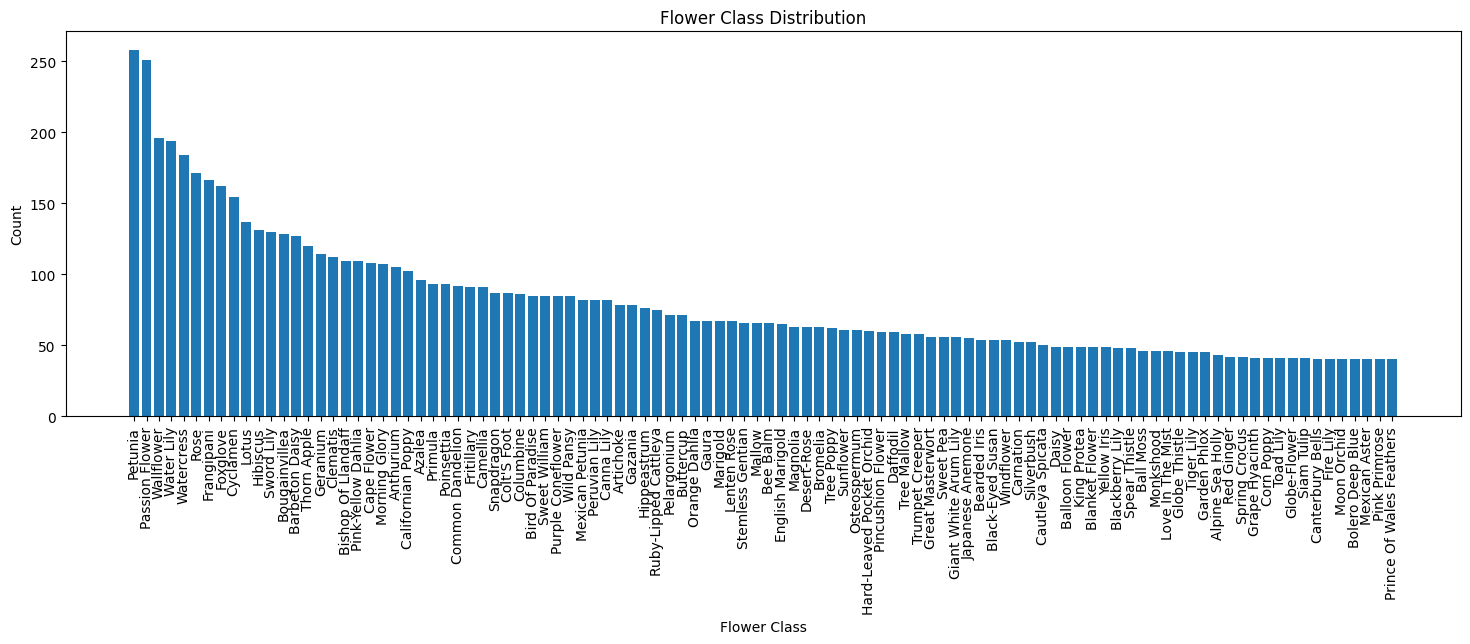

In [ ]:
get_class_distribution(flower_df)

In [ ]:
# df_stats = get_stats(flower_df, "/content/drive/MyDrive/Fellowship AI/S11_superconvergence")

In [ ]:
# plot_stats(df_stats)

In [ ]:
# df_stats.head()

In [ ]:
# show_image_classes(flower_df)

# Dataset and Transformations

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [10]:
tr_trans = [
              alb.Resize(height=256, width=256),
              alb.ShiftScaleRotate(shift_limit=0.4, scale_limit=0.5, rotate_limit=45, p=0.5),
              alb.HorizontalFlip(p= 0.75),
              alb.CenterCrop(224,224, always_apply= True),
              alb.Normalize(
                  mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225]
              ),
              ToTensor()
              ]

trans = Flowers102_AlbumTrans(tr_trans)
data = FLOWER102DataLoader(trans, batch_size=32)
train_loader, test_loader = data.get_loaders()
# display(train_loader, 32)

In [11]:
len(train_loader)

32

In [12]:
model = model_custom_ResNET()
model = model.to(device)
model_summary(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.5MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

## One-Cycle Policy -- LR Finder

In [13]:
wt_decay = 1e-3
mom = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, nesterov=True, weight_decay=wt_decay, momentum = mom)
optimizer.scheduler = None
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.1, num_iter=10 * len(train_loader), step_mode="exp")

  0%|          | 0/320 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


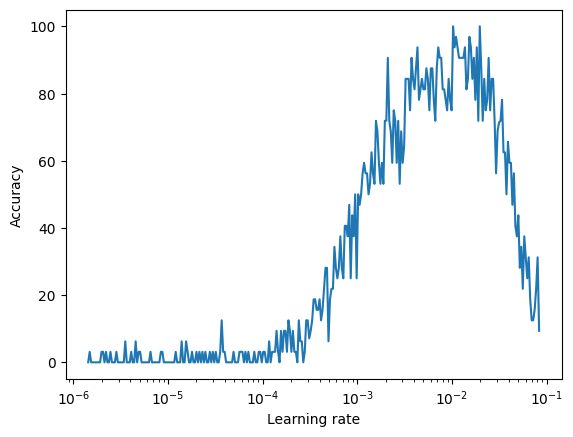

Best acc 100.0
Best LR:  0.010292933927393113


In [14]:
lr_finder.plot(plot_case="acc")
best_lr = lr_finder.get_best_lr(case="acc")

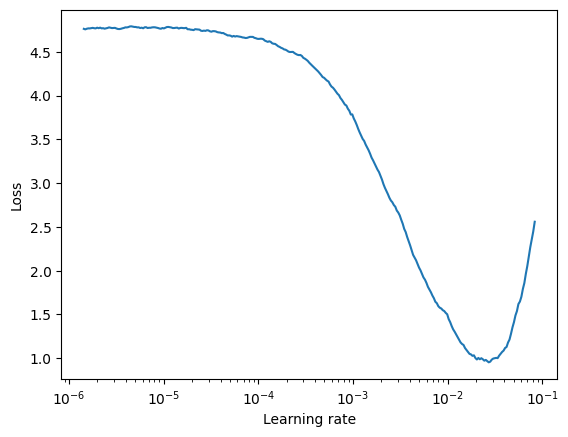

Best loss 0.9515183895020404
Best LR:  0.02727323641386823


In [15]:
lr_finder.plot(plot_case="loss")
best_loss_lr = lr_finder.get_best_lr(case="loss")

In [16]:
best_lr

0.010292933927393113

In [17]:
lr_finder.reset()

## Model Training

====================START====================
==================== EPOCH: 1 ====================


Loss=4.167628765106201 Batch_id=31 Accuracy=8.14: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


 Current LR: 0.0003216541852310347



Test set: Average loss: 0.1285, Accuracy: 162/1020 (15.88%)

==================== EPOCH: 2 ====================


Loss=2.9898922443389893 Batch_id=31 Accuracy=35.20: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


 Current LR: 0.0017819142949166474



Test set: Average loss: 0.0817, Accuracy: 609/1020 (59.71%)

==================== EPOCH: 3 ====================


Loss=1.8676395416259766 Batch_id=31 Accuracy=69.71: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


 Current LR: 0.005307294056312074



Test set: Average loss: 0.0415, Accuracy: 832/1020 (81.57%)

==================== EPOCH: 4 ====================


Loss=1.018484354019165 Batch_id=31 Accuracy=87.65: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


 Current LR: 0.0088326738177075



Test set: Average loss: 0.0273, Accuracy: 901/1020 (88.33%)

==================== EPOCH: 5 ====================


Loss=0.23655618727207184 Batch_id=31 Accuracy=94.90: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


 Current LR: 0.010292933927393113



Test set: Average loss: 0.0246, Accuracy: 898/1020 (88.04%)

==================== EPOCH: 6 ====================


Loss=0.24017487466335297 Batch_id=31 Accuracy=97.75: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


 Current LR: 0.010224936297848148



Test set: Average loss: 0.0188, Accuracy: 921/1020 (90.29%)

==================== EPOCH: 7 ====================


Loss=0.18781045079231262 Batch_id=31 Accuracy=98.43: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


 Current LR: 0.01002279820729065



Test set: Average loss: 0.0160, Accuracy: 936/1020 (91.76%)

==================== EPOCH: 8 ====================


Loss=0.1952093094587326 Batch_id=31 Accuracy=98.63: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


 Current LR: 0.009692033455896351



Test set: Average loss: 0.0158, Accuracy: 934/1020 (91.57%)

==================== EPOCH: 9 ====================


Loss=0.07958019524812698 Batch_id=31 Accuracy=98.82: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


 Current LR: 0.009241664443843936



Test set: Average loss: 0.0146, Accuracy: 951/1020 (93.24%)

==================== EPOCH: 10 ====================


Loss=0.1537732183933258 Batch_id=31 Accuracy=99.12: 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


 Current LR: 0.008683976063757797



Test set: Average loss: 0.0133, Accuracy: 955/1020 (93.63%)

==================== EPOCH: 11 ====================


Loss=0.10750754922628403 Batch_id=31 Accuracy=99.22: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


 Current LR: 0.008034180600861583



Test set: Average loss: 0.0134, Accuracy: 951/1020 (93.24%)

==================== EPOCH: 12 ====================


Loss=0.05592503398656845 Batch_id=31 Accuracy=99.41: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


 Current LR: 0.0073100027814927485



Test set: Average loss: 0.0123, Accuracy: 959/1020 (94.02%)

==================== EPOCH: 13 ====================


Loss=0.03306790813803673 Batch_id=31 Accuracy=99.71: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


 Current LR: 0.006531196288772994



Test set: Average loss: 0.0116, Accuracy: 959/1020 (94.02%)

==================== EPOCH: 14 ====================


Loss=0.12634004652500153 Batch_id=31 Accuracy=99.61: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


 Current LR: 0.0057190049336267096



Test set: Average loss: 0.0115, Accuracy: 964/1020 (94.51%)

==================== EPOCH: 15 ====================


Loss=0.10345812141895294 Batch_id=31 Accuracy=99.61: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


 Current LR: 0.004895583178997439



Test set: Average loss: 0.0113, Accuracy: 968/1020 (94.90%)

==================== EPOCH: 16 ====================


Loss=0.08220837265253067 Batch_id=31 Accuracy=99.90: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


 Current LR: 0.004083391823851154



Test set: Average loss: 0.0109, Accuracy: 968/1020 (94.90%)

==================== EPOCH: 17 ====================


Loss=0.051919884979724884 Batch_id=31 Accuracy=99.61: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


 Current LR: 0.003304585331131401



Test set: Average loss: 0.0106, Accuracy: 968/1020 (94.90%)

==================== EPOCH: 18 ====================


Loss=0.0342094786465168 Batch_id=31 Accuracy=99.90: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


 Current LR: 0.0025804075117625666



Test set: Average loss: 0.0107, Accuracy: 968/1020 (94.90%)

==================== EPOCH: 19 ====================


Loss=0.03782999888062477 Batch_id=31 Accuracy=99.80: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


 Current LR: 0.0019306120488663515



Test set: Average loss: 0.0103, Accuracy: 969/1020 (95.00%)

==================== EPOCH: 20 ====================


Loss=0.0406348742544651 Batch_id=31 Accuracy=99.90: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


 Current LR: 0.0013729236687802131



Test set: Average loss: 0.0102, Accuracy: 970/1020 (95.10%)

==================== EPOCH: 21 ====================


Loss=0.050532761961221695 Batch_id=31 Accuracy=99.90: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


 Current LR: 0.0009225546567277964



Test set: Average loss: 0.0106, Accuracy: 968/1020 (94.90%)

==================== EPOCH: 22 ====================


Loss=0.01929905079305172 Batch_id=31 Accuracy=99.31: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


 Current LR: 0.0005917899053334977



Test set: Average loss: 0.0103, Accuracy: 967/1020 (94.80%)

==================== EPOCH: 23 ====================


Loss=0.05019205063581467 Batch_id=31 Accuracy=99.71: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


 Current LR: 0.0003896518147759997



Test set: Average loss: 0.0102, Accuracy: 971/1020 (95.20%)

==================== EPOCH: 24 ====================


Loss=0.021766910329461098 Batch_id=31 Accuracy=99.71: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


 Current LR: 0.00032165418523103477



Test set: Average loss: 0.0104, Accuracy: 967/1020 (94.80%)



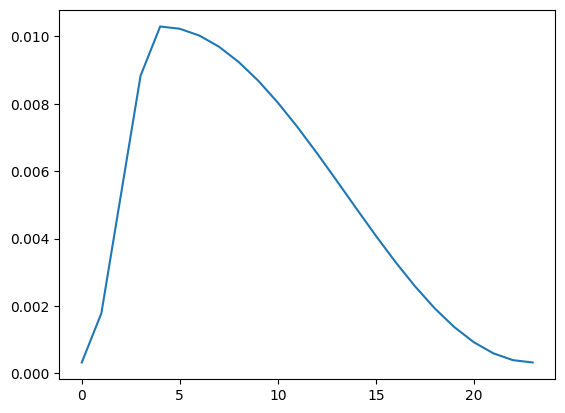

In [19]:
lr_list = []
key = "Custom_Resnet_FC_V1"
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), best_lr, nesterov=True, weight_decay=1e-4, momentum = 0.8)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                  max_lr=best_lr,
                  total_steps=24,
                  steps_per_epoch = len(train_loader),
                  epochs=24,
                  pct_start=5/24,
                  cycle_momentum=False,
                  div_factor=32,
                  final_div_factor=1,
                  anneal_strategy ='cos',
                  #annihilation_frac=0,
                  last_epoch=-1)
 # print('='*30 + f' div: {i} ' + '='*30)
epochs = 24
print('='*20 + 'START' + '='*20)
test = Test(model, device, test_loader, key)
train = Train(model, device, train_loader, optimizer, l1=0)
for epoch in range(epochs):
    print('='*20 + f' EPOCH: {epoch+1} ' + '='*20)
    train.train(epoch)
    lr_list.append(optimizer.param_groups[0]['lr'])
    print('\n Current LR:',lr_list[epoch])
    test.test()
    scheduler.step() #Have to give the val_loss or val_accuracy here. The metric on which we can to check
    #test.test()
  #fig, axs = plt.subplots(4,1,figsize=(15,10))
plt.plot(lr_list)


# Result Analysis

In [11]:
import Packages.plot
from Packages.plot import mis, gen_cam, plot_pred_cam, plot_act_cam
from Packages.graphs import acc_loss, testvtrain, class_acc

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Load Best Model

In [13]:
key = "Custom_Resnet_FC_V1"
best_model = model_custom_ResNET(params = False).to(device)
best_model.load_state_dict(torch.load(f'/content/drive/MyDrive/Fellowship AI/S11_superconvergence/Classifiers/classifier_{key}.pt'))
best_model.eval()
print('Best Model Loaded!')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 243MB/s]


Best Model Loaded!


Directory  /content/mis_class/  Created 
Directory  /content/mis_class/images  Created 

Test set: Average loss: 0.3244, Accuracy: 971/1020 (95.20%)

torch.Size([49, 3, 224, 224])


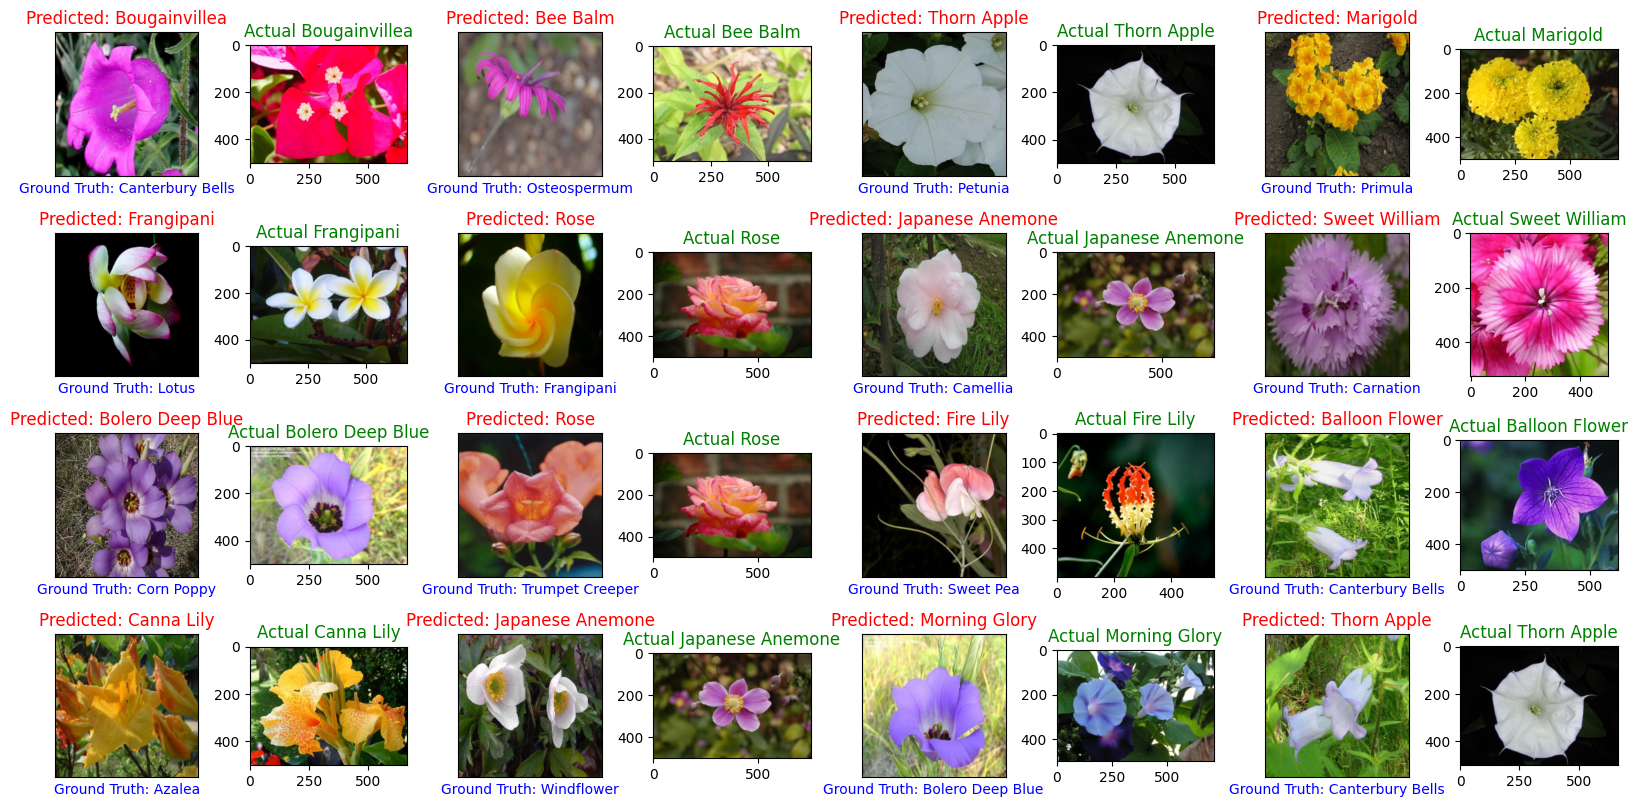

In [14]:

mis(best_model, device, test_loader, 16)

In [15]:
layers = ['layer1','layer2','layer3', 'layer4',]
for layer in layers:
  gen_cam(best_model, layer) #GradCAM for Misclassified w.r.t Predicted Class
  gen_cam(best_model, layer, class_idx= Packages.plot.true_list) #GradCAM for Misclassified w.r.t Actual Class

Directory  /content/result_pred/  Created 
Directory  /content/heatmap_pred/  Created 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Directory  /content/result_act/  Created 
Directory  /content/heatmap_act/  Created 
Directory  /content/result_pred/  already exists
Directory  /content/heatmap_pred/  already exists
Directory  /content/result_act/  already exists
Directory  /content/heatmap_act/  already exists
Directory  /content/result_pred/  already exists
Directory  /content/heatmap_pred/  already exists
Directory  /content/result_act/  already exists
Directory  /content/heatmap_act/  already exists
Directory  /content/result_pred/  already exists
Directory  /content/heatmap_pred/  already exists
Directory  /content/result_act/  already exists
Directory  /content/heatmap_act/  already exists


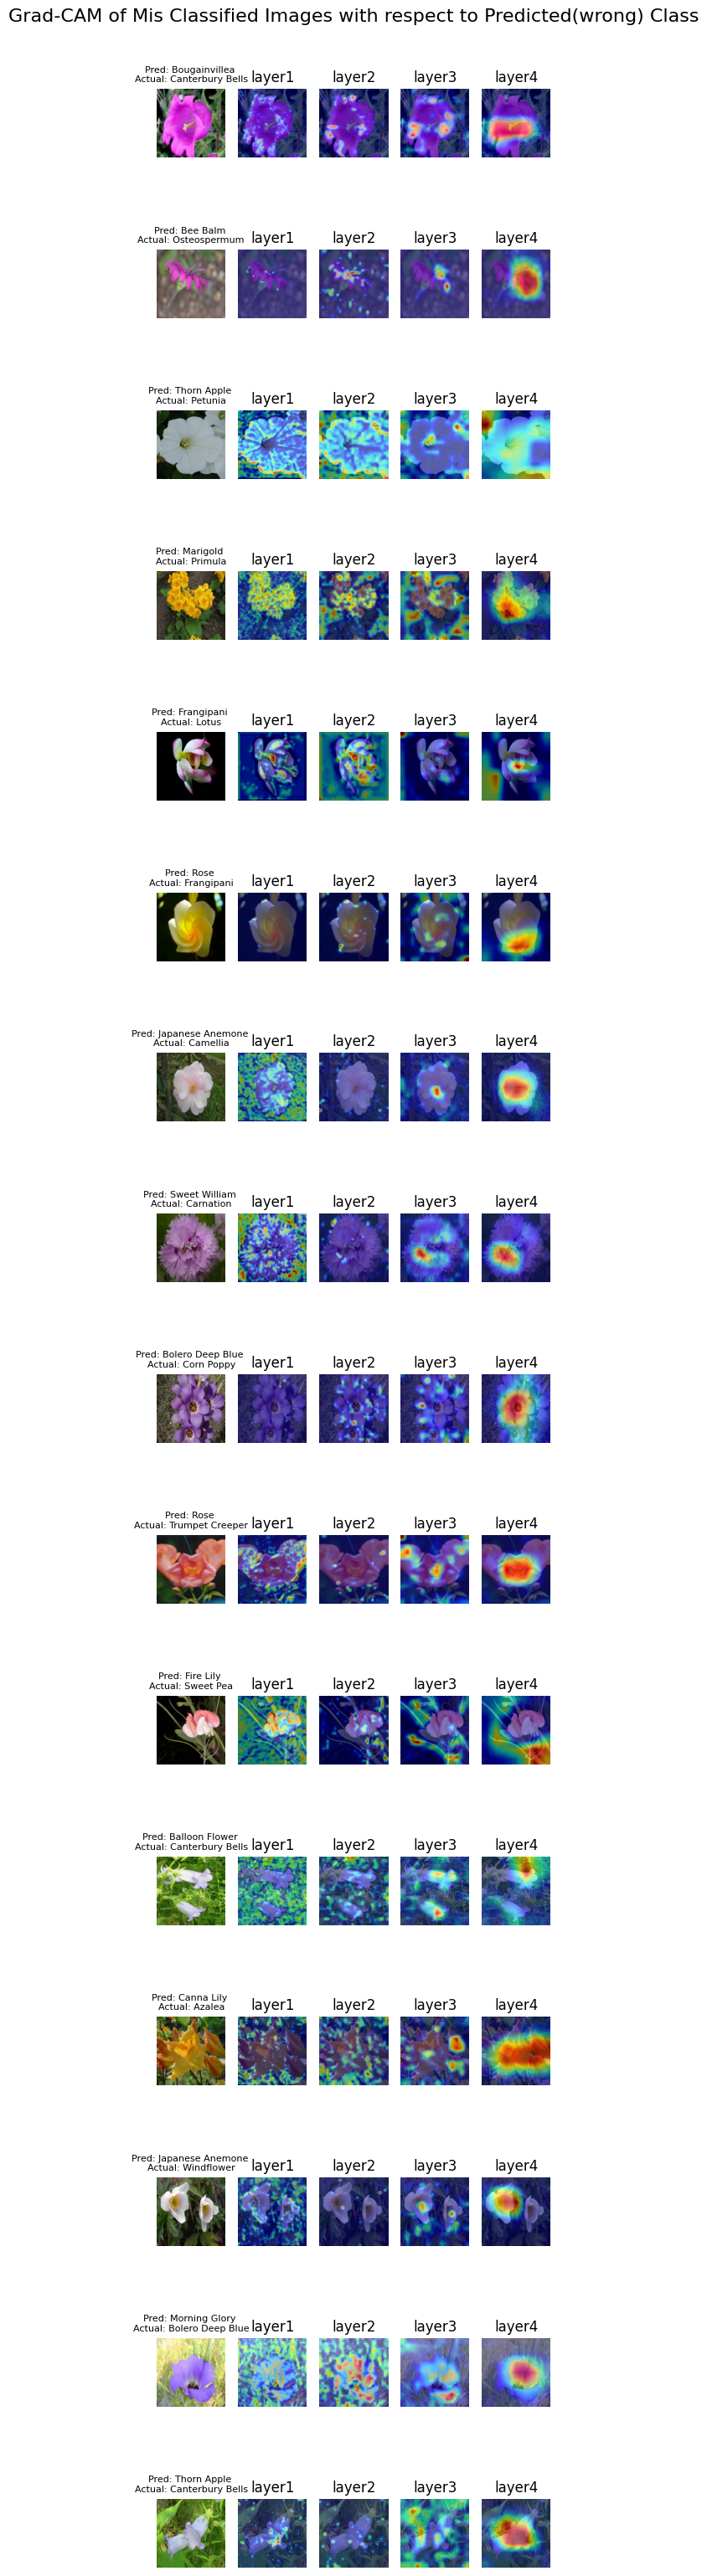

In [16]:
plot_pred_cam(16, layers, 4)

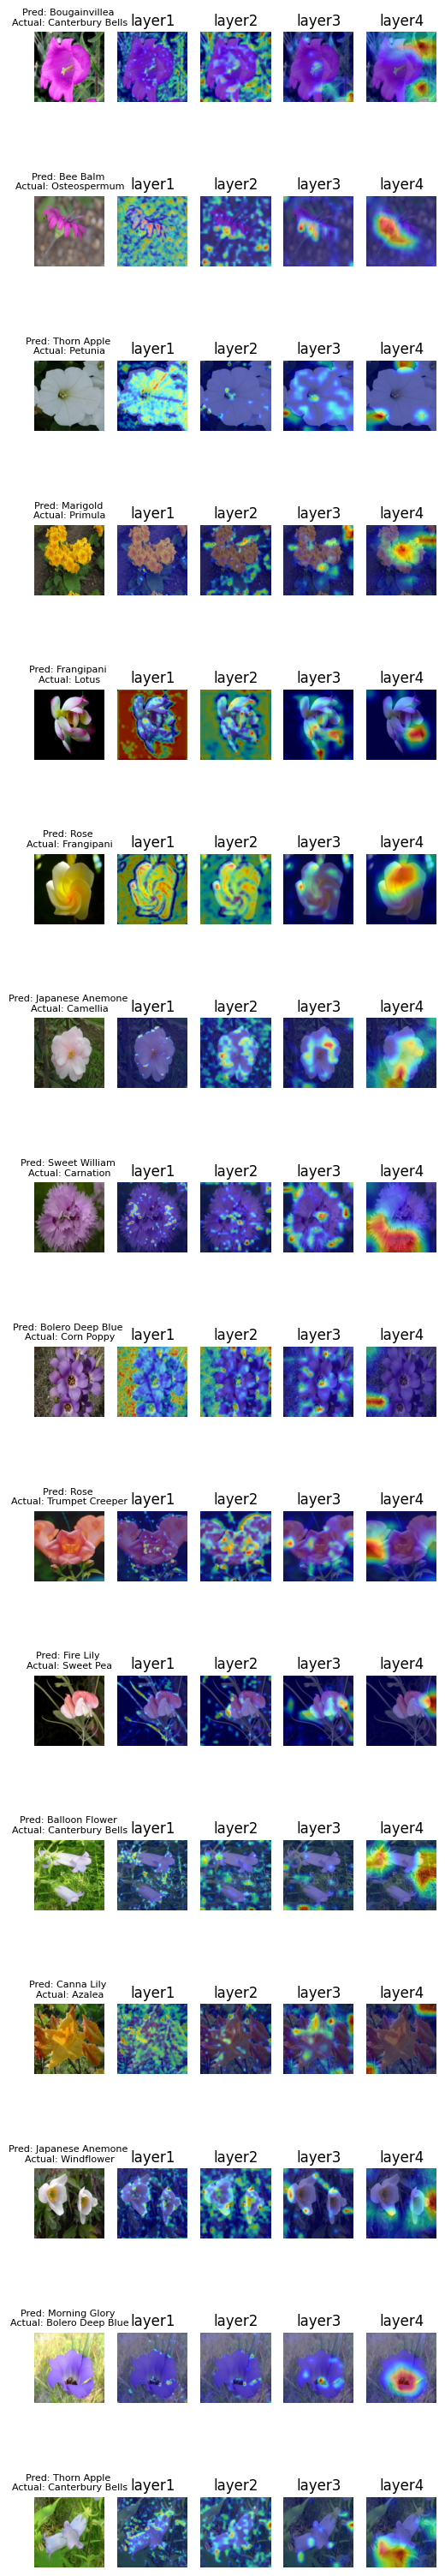

In [17]:
plot_act_cam(16,layers, 4)

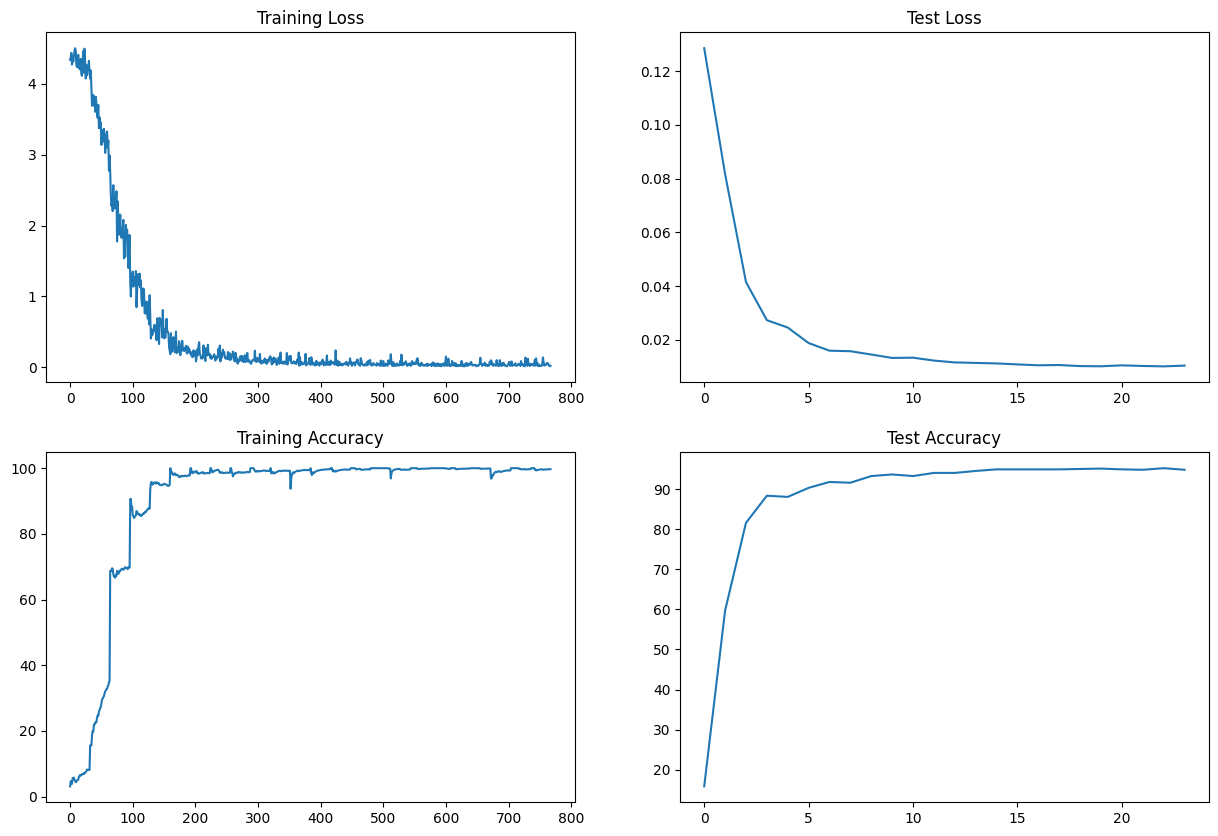

In [29]:
acc_loss(train, test)

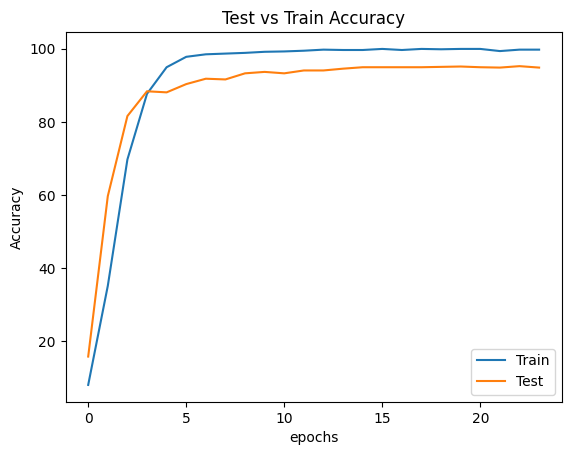

In [30]:
testvtrain(train, test)

In [31]:
class_acc(model, device, test_loader)

Accuracy of pink primrose : 100 %
Accuracy of hard-leaved pocket orchid : 100 %
Accuracy of canterbury bells : 60 %
Accuracy of sweet pea : 70 %
Accuracy of english marigold : 100 %
Accuracy of tiger lily : 100 %
Accuracy of moon orchid : 100 %
Accuracy of bird of paradise : 100 %
Accuracy of monkshood : 90 %
Accuracy of globe thistle : 100 %
Accuracy of snapdragon : 40 %
Accuracy of colt's foot : 100 %
Accuracy of king protea : 100 %
Accuracy of spear thistle : 100 %
Accuracy of yellow iris : 100 %
Accuracy of globe-flower : 100 %
Accuracy of purple coneflower : 100 %
Accuracy of peruvian lily : 90 %
Accuracy of balloon flower : 90 %
Accuracy of giant white arum lily : 100 %
Accuracy of fire lily : 100 %
Accuracy of pincushion flower : 90 %
Accuracy of fritillary : 90 %
Accuracy of red ginger : 100 %
Accuracy of grape hyacinth : 100 %
Accuracy of corn poppy : 90 %
Accuracy of prince of wales feathers : 80 %
Accuracy of stemless gentian : 100 %
Accuracy of artichoke : 100 %
Accuracy of